In [2]:
import yfinance as yf
import pandas as pd

stock = yf.Ticker("GOOG")

In [66]:
df = yf.download(tickers="GOOG", period="1d", interval="1m")
stock.history(period='1d', interval="1m")
print(df.head())

[*********************100%***********************]  1 of 1 completed
                           Open        High         Low       Close  \
Datetime                                                              
2023-10-03 09:30:00  134.929993  135.110001  134.589996  134.649994   
2023-10-03 09:31:00  134.619995  134.690002  134.160004  134.179993   
2023-10-03 09:32:00  134.179993  134.320007  134.065002  134.300003   
2023-10-03 09:33:00  134.304993  134.544998  134.304993  134.309998   
2023-10-03 09:34:00  134.354996  134.491806  134.289993  134.419998   

                      Adj Close  Volume  
Datetime                                 
2023-10-03 09:30:00  134.649994  543374  
2023-10-03 09:31:00  134.179993   96864  
2023-10-03 09:32:00  134.300003  107288  
2023-10-03 09:33:00  134.309998   63752  
2023-10-03 09:34:00  134.419998   49106  


In [67]:
#df = stock.history(period='7d', interval="1m")
df = df[["Open", "High", "Low", "Close", "Volume"]]
df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-10-03 09:30:00,134.929993,135.110001,134.589996,134.649994,543374
2023-10-03 09:31:00,134.619995,134.690002,134.160004,134.179993,96864
2023-10-03 09:32:00,134.179993,134.320007,134.065002,134.300003,107288
2023-10-03 09:33:00,134.304993,134.544998,134.304993,134.309998,63752
2023-10-03 09:34:00,134.354996,134.491806,134.289993,134.419998,49106


In [68]:
X = df.index.values
y = df['Low'].values# The split point is the 10% of the dataframe length
offset = int(0.10*len(df))

X_train = X[:-offset]
y_train = y[:-offset]
X_test  = X[-offset:]
y_test  = y[-offset:]

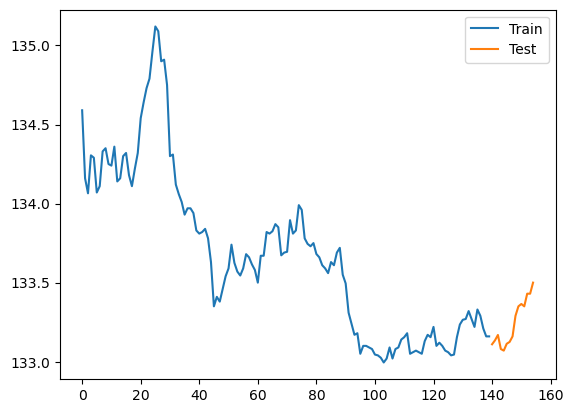

In [69]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(y_train)),y_train, label='Train')
plt.plot(range(len(y_train),len(y)),y_test,label='Test')
plt.legend()
plt.show()

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(5,0,1)).fit()
forecast = model.forecast(steps=1)[0]

e:\Programming\stock-trading\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
model.forecast(steps=1)

array([133.52518122])

In [72]:
from backtesting import Backtest
from backtesting.lib import TrailingStrategy, crossover

class ARIMA_model(TrailingStrategy):
    def init(self):
        super().init()
        self.set_trailing_sl(3)
        self.y = self.data.Low

    

    def next(self):
        super().next()

        model = ARIMA(self.y, order=(5,0,1)).fit()
        self.forecast = model.forecast(steps=1)[0]

        if self.data.Close[-1]<self.forecast:
            self.buy(size=0.6)
        if self.data.Close[-1]>self.forecast:
            self.sell(size=0.6)
        


In [73]:
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-10-03 09:30:00,134.929993,135.110001,134.589996,134.649994,543374
2023-10-03 09:31:00,134.619995,134.690002,134.160004,134.179993,96864
2023-10-03 09:32:00,134.179993,134.320007,134.065002,134.300003,107288
2023-10-03 09:33:00,134.304993,134.544998,134.304993,134.309998,63752
2023-10-03 09:34:00,134.354996,134.491806,134.289993,134.419998,49106
...,...,...,...,...,...
2023-10-03 12:01:00,133.380005,133.460007,133.365005,133.399994,59169
2023-10-03 12:02:00,133.388504,133.470001,133.350006,133.449997,26518
2023-10-03 12:03:00,133.455002,133.529999,133.430099,133.430099,23474


In [74]:
bt = Backtest(df, ARIMA_model,
            cash=100000, trade_on_close=False, exclusive_orders=True)

stats = bt.run()

e:\Programming\stock-trading\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Programming\stock-trading\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Programming\stock-trading\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Programming\stock-trading\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Programming\stock-trading\.conda\lib\site-packages\st

6. Comparing strategy returns to performance range of stocks

In [75]:
import numpy as np

print("OC-Range: ", (df["Close"].iloc[-1]-df["Close"].iloc[0])/df["Close"].iloc[0])
print("HL-Range: ", (np.max(df["Close"])-np.min(df["Close"]))/np.min(df["Close"]))

OC-Range:  -0.008540616031282276
HL-Range:  0.016012065254970047


7. Optimized Strategy Statistics

In [76]:
stats

Start                     2023-10-03 09:30:00
End                       2023-10-03 12:05:00
Duration                      0 days 02:35:00
Exposure Time [%]                   98.709677
Equity Final [$]                100548.287338
Equity Peak [$]                 100579.860641
Return [%]                           0.548287
Buy & Hold Return [%]               -0.854062
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.452701
Avg. Drawdown [%]                   -0.117704
Max. Drawdown Duration        0 days 00:44:00
Avg. Drawdown Duration        0 days 00:14:00
# Trades                                  153
Win Rate [%]                        49.673203
Best Trade [%]                       0.319009
Worst Trade [%]                     -0.247548
Avg. Trade [%]                    